# Dekompozycja szeregu

W trakcie budowy modelu przeprowadza się **dekompozycje szeregu czasowego** w zależności od przyjętych założeń.

**Oznaczenia**: $m_t$ - trend, $s_t$ - sezonowość, $\varepsilon_t$ - szum.

**Model addytywny** - wielkość wahań sezonowych lub wariancja danych wokół tendencji długoterminowej (trendu) nie zmienia się wraz z poziomem szeregu:
$$y_t = m_t + s_t + \varepsilon_t$$

**Model multiplikatywny** - amplituda wahań sezonowych lub wariancja danych proporcjonalna do poziomu szeregu:
$$y_t = m_t \cdot s_t \cdot \varepsilon_t$$


In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

#from google.colab import files
#src = list(files.upload().values())[0]
#open('ts_utils.py','wb').write(src)

#from ts_utils import check_time_series_stationary

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import adfuller
def check_time_series_stationary(y, rolling_len = 12):
    
    y = pd.Series(y)
    
    df_test = adfuller(y)
    
    if df_test[1] < 0.05:
        print('Szereg jest stacjonarny')
    else:
        print('Szereg jest niestacjonarny')
    
    print("{0:^32s}".format("Dickey-Fuller Test"))
    print("-"*32+"\n")
    
    print("{0:<20s}: {1:>10.4f}".format('Test Statistic', df_test[0]))
    print("{0:<20s}: {1:>10.4f}".format('p-value', df_test[1]))
    print("-"*32+"\n")
    
    rolling_mean = y.rolling(rolling_len).mean()
    rolling_var = y.rolling(rolling_len).var()

    plt.plot(y)
    plt.plot(rolling_mean, label="Rolling mean")
    plt.plot(rolling_var, label="Rolling var")
    plt.legend()
    plt.show()
    
    print("{0:^32s}".format("Autocorrelation plot"))
    print("-"*32+"\n")
    pd.plotting.autocorrelation_plot(y)
    plt.show()

## Algorytm dekompozycji szeregu czasowego

1. Wyznaczamy oszacowany składnik trendu $\hat{m_t}$, wykorzystując np. metodę średniej ruchomej.
2. Oszacowany trend jest eliminowany z danych. Wyznaczamy szereg:

    a) dekompozycja addytywna: $y_t - \hat{m_t}$,
    
    b) dekompozycja multiplikatywna: $y_t/\hat{m_t}$.
    
3. Wyznaczamy indeksy sezonowe dla poszczególnych miesięcy, kwartałów, itd. Indeksy sezonowe są wyznaczane poprzez uśrednienie wartości szeregu z kroku 2 dla każdej jednostki czasu (np. miesiąc, kwartał) i wszystkich okresów (lat).
4. Standaryzujemy wskaźniki sezonowe, tak aby nie miały one wpływu na tendencję długoterminową.
5. Wyznaczamy reszty, usuwając trend i sezonowość

    a) dekompozycja addytywna: $\varepsilon_t = y_t - \hat{m_t} - \hat{s_t}$,
    
    b) dekompozycja multiplikatywna: $\varepsilon_t = y_t/\hat{m_t}/\hat{s_t}$.


## ***Zadanie 1

a) Przy użyciu metody średniej ruchomej oszacuj trend dla szeregu `southern`, wiedząc, że dla szeregu długości $n$, tzn. $Y_1, \ldots, Y_n$ estymacja średniej ruchomej w chwili $t$ jest postaci:
$$m(t)=\frac{1}{2q+1}\sum_{i=-q}^qY_{t-i},$$
gdzie $q$ jest rzędem średniej ruchomej (np. `convolution_filter` z `statsmodels.tsa.filters.filtertools`). 

Innymi słowy, aby wyznaczyć oszacowaną wartość trendu w chwili $t$, uśredniamy $q$ poprzedzających ten moment wartości i $q$ wartości następujących po tym momencie.

b) Następnie wyznacz indeksy sezonowe dla mięsięcy a następnie wystandaryzuj je przez średnią.

c) Oszacuj wartość reszt szeregu, sprawdź jego stacjonarność.

Załóż, że szereg `southern` jest szeregiem addytywnym.

In [4]:
#chcemy dekomponować szereg, ponieważ łatwiej jest modelować poszczególne części (np. trend regrsją liniową czy wielomianową)
#sezonowość, przez powtarzanie dla konkretnych miesięcy, średnich wyliczonych na danych miesiącach na części uczącej pozbawionej trendu
#losowość (jeśli stacjonarna to np. ARMA)
southern = pd.read_csv('southern.csv', 
                 parse_dates=['Date'], index_col='Date')

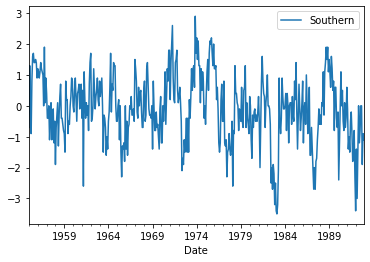

In [ ]:
southern.plot()

#### Oszacowanie trendu

In [5]:
from statsmodels.tsa.filters.filtertools import convolution_filter
# używamy metody convolution_filter, jeśli n_sizes = 2 sumujemy wszystkie elmenty odległe o freq/2 z dwóch stron od zadanego punktu i tak przechodzimy punkt po punkcie
# innymi słowy robimy sumę ruchomą

In [6]:
#średnia ruchoma
period = 12
trend = convolution_filter(southern.Southern, np.ones(period + 1), nsides=2) / (period + 1)

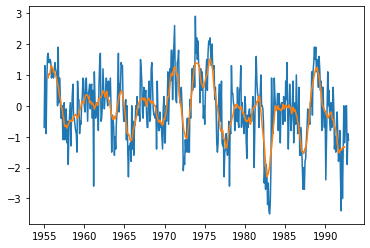

In [7]:
#wykres średniej ruchomej
plt.plot(southern)
plt.plot(trend)

#### Oszacowanie sezonowości

In [8]:
#wyrzucamy trend
detrended = southern.Southern - trend
#liczymy na szeregu bez trendu średnie dla poszczególnych miesięcy
month_avgs = np.array([np.nanmean(detrended[i::period], axis=0) for i in range(period)])
month_avgs -= np.mean(month_avgs, axis=0)
#powtarzamy średnie tyle razy ile mamy lat, w efekcie mamy szereg długości southern, 
#gdzie dla każdego miesiąca w każdym roku, mamy średnią wyliczoną dla danego miesiąca 
seasonal = np.tile(month_avgs.T, southern.size // period).T
seasonal = pd.Series(seasonal, index=southern.index)

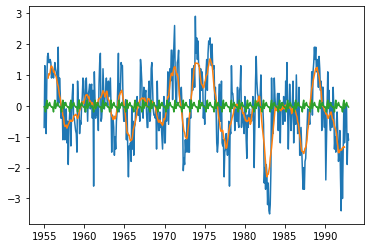

In [9]:
plt.plot(southern)
plt.plot(trend)
plt.plot(seasonal)
#zielona linia ma bardzo powtarzalny sezon

#### Oszacowanie elementu losowego i diagnostyka stacjonarności

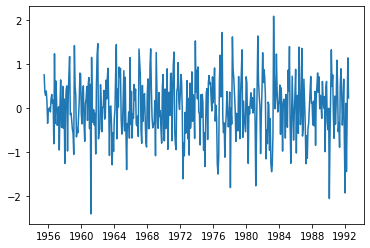

In [10]:
#rozpatrujemy część losową - bez średniej i bez trendu
resid = detrended - seasonal
plt.plot(resid)

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -7.9729
p-value             :     0.0000
--------------------------------



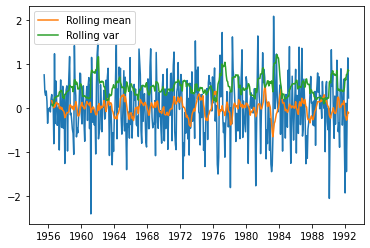

      Autocorrelation plot      
--------------------------------



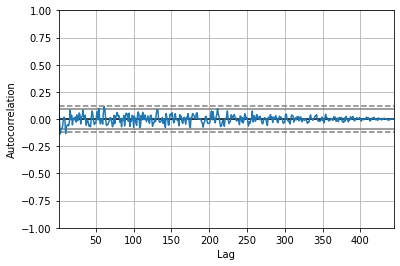

In [11]:
check_time_series_stationary(resid.dropna())
#stacjonarny

## Zadanie 2
Dokonaj dekompozycji szeregu przy użyciu `seasonal_decompose` dla następujących danych:
- `southern`,
- `a10`,
- `AirPassengers`, 
- `sunspots`.

### `southern`

In [12]:
southern = pd.read_csv('southern.csv', 
                 parse_dates=['Date'], index_col='Date')

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -6.1813
p-value             :     0.0000
--------------------------------



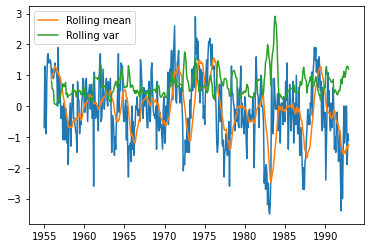

      Autocorrelation plot      
--------------------------------



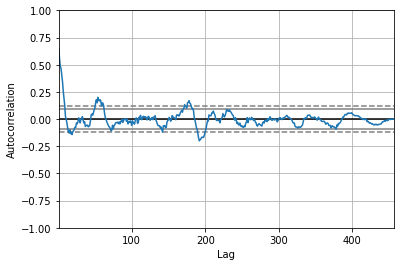

In [13]:
check_time_series_stationary(southern.Southern)
#według testu d-f stacjonarny, ale wykres acf pokazuje sezonowość

In [14]:
southern_dec= seasonal_decompose(southern, model='additive') #dekompozycja, wariancja nie zmienia sięze wzrostem szeregu - model addytywny

In [15]:
southern_dec.trend # trend
southern_dec.seasonal # sezonowosc
southern_dec.resid.head(13) # reszty

Date
1955-01-01         NaN
1955-02-01         NaN
1955-03-01         NaN
1955-04-01         NaN
1955-05-01         NaN
1955-06-01         NaN
1955-07-01    0.695571
1955-08-01    0.375413
1955-09-01    0.254692
1955-10-01    0.296134
1955-11-01    0.124174
1955-12-01   -0.336862
1956-01-01   -0.017380
Name: resid, dtype: float64

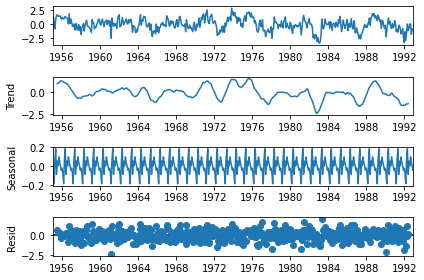

In [16]:
southern_dec.plot( )
plt.show()

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -7.9992
p-value             :     0.0000
--------------------------------



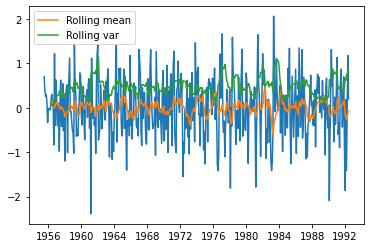

      Autocorrelation plot      
--------------------------------



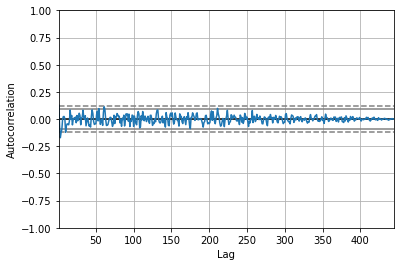

In [18]:
check_time_series_stationary(southern_dec.resid.dropna())
#losowość stacjonarna

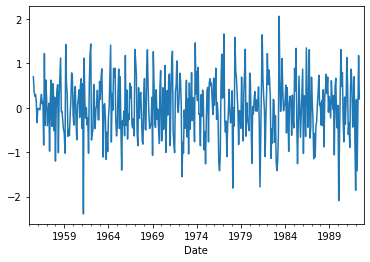

In [19]:
southern_dec.resid.plot()
#wykres części losowej

### `a10`

In [20]:
a10 = pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')
a10.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


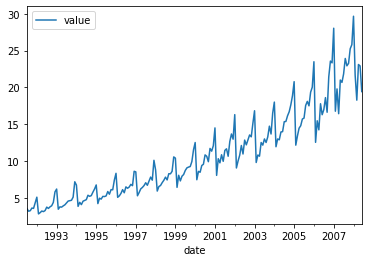

In [21]:
a10.plot()

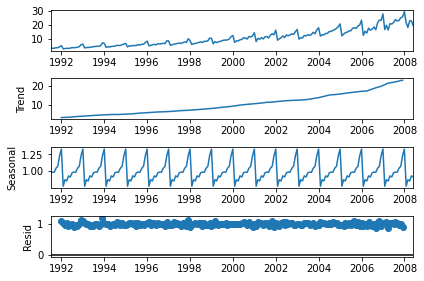

In [22]:
a10_dec = seasonal_decompose(a10, model='multiplicative') #wariancja rośnie wraz ze wzrostem szeregu - model multiplikatywny
a10_dec.plot()
plt.show()

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -5.9908
p-value             :     0.0000
--------------------------------



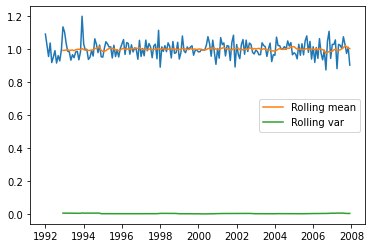

      Autocorrelation plot      
--------------------------------



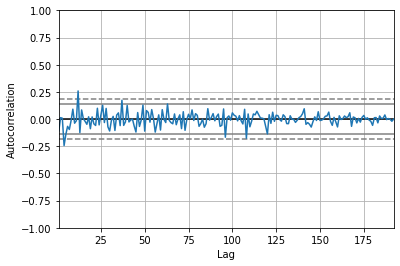

In [24]:
check_time_series_stationary(a10_dec.resid.dropna()) #stacjonarność na cześci losowej

### `AirPassengers`

In [26]:
air_passengers = pd.read_csv('AirPassengers.csv', 
                 parse_dates=['Month'], index_col='Month')

air_passengers.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


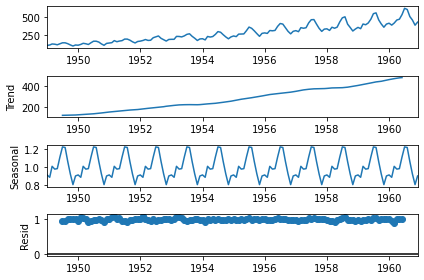

In [27]:
air_passengers_decomposition = seasonal_decompose(air_passengers, model='multiplicative') #wariancja rośnie wraz ze wzrostem szeregu - model multiplikatywny
air_passengers_decomposition.plot()
plt.show()

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -7.4159
p-value             :     0.0000
--------------------------------



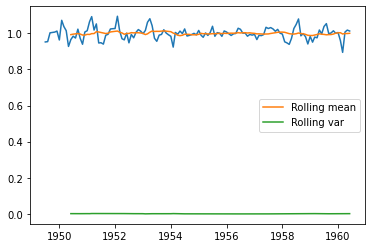

      Autocorrelation plot      
--------------------------------



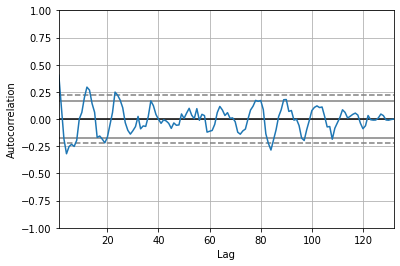

In [29]:
check_time_series_stationary(air_passengers_decomposition.resid.dropna()) #część losowa jest stacjonarna według testu d-f, ale patrząc na acf może być sezon
#dekompozycja nie zawsze daje w części losowej szereg stacjonarny - można próbować opisać to szeregiem SARIMA (seasonal ARIMA) (funkcja sarimax)
#https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html

### `sunspot` 
Time Series:
Start = 1700 
End = 1988 
Frequency = 1 

In [30]:
sunspot = pd.read_csv('sunspot.csv')
sunspot

,value
0,5.0
1,11.0
2,16.0
3,23.0
4,36.0
...,...
284,45.9
285,17.9
286,13.4
287,29.2


In [31]:
sunspot.index = pd.date_range('1700', '1988', freq='AS') #nadajemy rok jako indeks dla poszczególnych obserwacji
sunspot

,value
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0
...,...
1984-01-01,45.9
1985-01-01,17.9
1986-01-01,13.4
1987-01-01,29.2


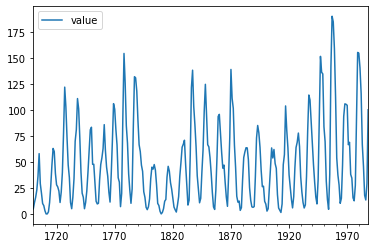

In [32]:
sunspot.plot() #sezonowość jest, ale wariancja mniej więcej równa

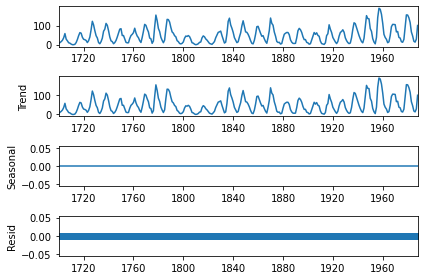

In [33]:
sunspot_dec = seasonal_decompose(sunspot, model='additive')
sunspot_dec.plot()
plt.show() #jest problem bo trend to to samo co szereg obserwowany - szereg nie ma określonej częstotliwości

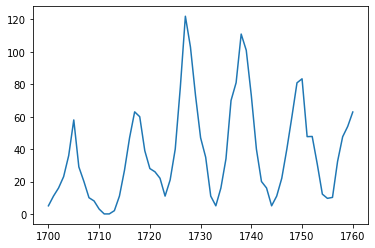

In [34]:
plt.plot(sunspot[(sunspot.index >= '1700') & (sunspot.index <= '1760')])
plt.show() #mniej więcej co 10-11 lat się to wszystko powtarza

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


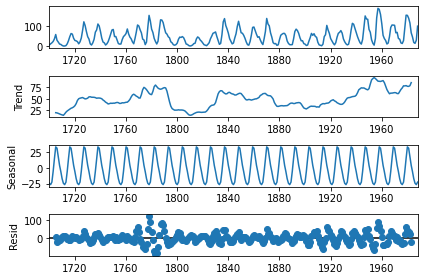

In [35]:
sunspot_dec = seasonal_decompose(sunspot, model='additive', freq=11) #nadajemy freq = 11
sunspot_dec.plot()
plt.show()

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -8.8411
p-value             :     0.0000
--------------------------------



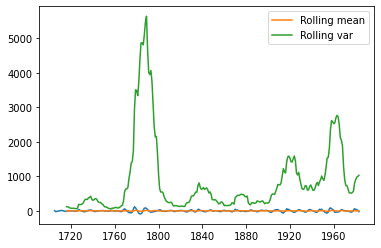

      Autocorrelation plot      
--------------------------------



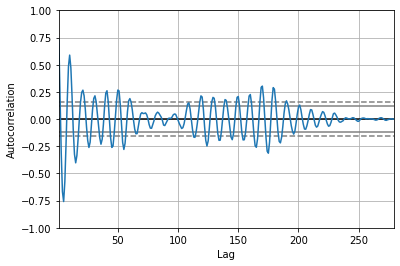

In [37]:
check_time_series_stationary(sunspot_dec.resid.dropna()) #niby wg. testu d-f jest ok, ale acfy nam pokazują, że w części losowej jest sezonowość